In [1]:
# TRAINING PINN FOR BBH DYNAMICS (NO SPINS, WITH INITIAL CONDITIONS)

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# === 1. LOAD DATA ===
df = pd.read_csv("precessing_waveform_dataset.csv")

# Inputs: time and q
X = df[['time', 'q']].values
Y = df[['phi', 'r', 'omega', 'h22_real', 'h22_imag']].values

# Normalise
gx = StandardScaler()
gy = StandardScaler()
X_scaled = gx.fit_transform(X)
Y_scaled = gy.fit_transform(Y)

# Split
torch.manual_seed(42)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2)

X_train = torch.tensor(X_train, dtype=torch.float32, requires_grad=True)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

# === 2. DEFINE MODEL ===
class PINN(nn.Module):
    def __init__(self, input_dim=2, output_dim=5, hidden=128, layers=5):
        super(PINN, self).__init__()
        layers_list = [nn.Linear(input_dim, hidden), nn.Tanh()]
        for _ in range(layers):
            layers_list += [nn.Linear(hidden, hidden), nn.Tanh()]
        layers_list.append(nn.Linear(hidden, output_dim))
        self.net = nn.Sequential(*layers_list)

    def forward(self, x):
        return self.net(x)

# === 3. DEFINE LOSSES ===
def omega_phi_loss(phi_pred, omega_pred, t_input):
    dphi_dt = finite_difference(phi_pred, t_input)
    return torch.mean((dphi_dt - omega_pred) ** 2)


def finite_difference(y, t):
    dt = t[1:] - t[:-1]
    dy = y[1:] - y[:-1]
    dy_dt = dy / (dt + 1e-8)
    # Pad to match original length
    return torch.cat([dy_dt[:1], dy_dt], dim=0)


def energy_constraint_loss(r_pred, q_input):
    nu = q_input / (1 + q_input)**2  # symmetric mass ratio
    F_e = 1.0  # assuming circular orbits
    dEdt_expected = - (32/5) * nu**2 * (1 / (r_pred + 1e-8))**5 * F_e
    return torch.mean(dEdt_expected**2)  # forcing energy loss to follow expected law

def r_omega_constraint_loss(r_pred, omega_pred):
    r_expected = (1.0 / (omega_pred ** 2 + 1e-8)) ** (1/3)
    return torch.mean((r_pred - r_expected) ** 2)

def radius_decay_loss(r_pred, q_input, t_input):
    nu = q_input / (1 + q_input)**2
    F_e = 1.0
    dr_dt = finite_difference(r_pred, t_input)
    drdt_expected = - (64 / 5) * nu * (1 / (r_pred + 1e-8))**3 * F_e
    return torch.mean((dr_dt - drdt_expected)**2)

def initial_condition_loss(model, X_scaled, Y_scaled):
    model.eval()
    with torch.no_grad():
        t_min = torch.min(X_scaled[:, 0])
        mask = (X_scaled[:, 0] == t_min)
        X_t0 = X_scaled[mask]
        Y_t0 = Y_scaled[mask]
        pred_t0 = model(X_t0)
    return torch.mean((pred_t0 - Y_t0)**2)

def waveform_phase_constraint_loss(phi_pred, h_real_pred, h_imag_pred):
    h_pred = h_real_pred + 1j * h_imag_pred
    h_expected = torch.exp(-2j * phi_pred.squeeze())  # unit amplitude approximation
    return torch.mean(torch.abs(h_pred - h_expected)**2)

def waveform_projection_loss(phi_pred, h_real_pred, h_imag_pred):
    cos2phi = torch.cos(2 * phi_pred.squeeze())
    sin2phi = torch.sin(2 * phi_pred.squeeze())
    h_plus_target = cos2phi
    h_cross_target = -sin2phi
    return torch.mean((h_real_pred - h_plus_target)**2 + (h_imag_pred - h_cross_target)**2)

def fourier_loss(h_pred, h_true):
    # Assume input: [batch_size, time_series_length] or just [N]
    h_pred_fft = torch.fft.fft(h_pred)
    h_true_fft = torch.fft.fft(h_true)
    
    # Use magnitude only (you can also use log-magnitude or full complex difference)
    h_pred_mag = torch.abs(h_pred_fft)
    h_true_mag = torch.abs(h_true_fft)

    return torch.mean((h_pred_mag - h_true_mag)**2)



# === 4. TRAINING ===
model = PINN(input_dim=2, output_dim=5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

epochs = 1000
lambda_omega = 0.1
lambda_energy = 0.05
lambda_romega = 0.1
lambda_radius = 0.1
lambda_ic = 0.1  # Weight for initial condition loss
lambda_waveform = 10
lambda_fourier = 0

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    pred = model(X_train)

    phi_pred = pred[:, 0:1]      # phi
    r_pred = pred[:, 1:2]        # r(t)
    omega_pred = pred[:, 2:3]    # omega(t)
    h22_pred = pred[:, 3:5]      # waveform

    t_input = X_train[:, 0].unsqueeze(1)

    loss_data = loss_fn(pred, Y_train)
    loss_energy = energy_constraint_loss(r_pred, X_train[:, 1:2])
    loss_radius = radius_decay_loss(r_pred, X_train[:, 1:2], t_input)
    loss_omega = omega_phi_loss(phi_pred, omega_pred, t_input)
    loss_romega = r_omega_constraint_loss(r_pred, omega_pred)
    loss_ic = initial_condition_loss(model, X_train, Y_train)
    loss_waveform = waveform_phase_constraint_loss(phi_pred, h22_pred[:,0], h22_pred[:,1])
    loss_waveform_proj = waveform_projection_loss(phi_pred, h22_pred[:, 0], h22_pred[:, 1])
    loss_fourier_plus = fourier_loss(Y_train[:, 3].squeeze(), h22_pred[:,0].squeeze())
    loss_fourier_cross = fourier_loss(Y_train[:, 4].squeeze(), h22_pred[:,1].squeeze())



    total_loss = (
        loss_data
        + lambda_waveform * loss_waveform_proj
        + lambda_fourier * (loss_fourier_plus + loss_fourier_cross)
        # + lambda_energy * loss_energy
        # + lambda_omega * loss_omega
        # + lambda_romega * loss_romega
        # + lambda_ic * loss_ic
        # + lambda_radius * loss_radius  # peso configurable
    )


    total_loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        model.eval()
        with torch.no_grad():
            val_loss = loss_fn(model(X_test), Y_test)
        print(f"Epoch {epoch:4d} | Train Loss: {total_loss.item():.4e} | Val Loss: {val_loss.item():.4e}")

# # Save model
# torch.save(model.state_dict(), "pinn_bbh_nospin.pth")
# print("\n Training complete. Model saved as 'pinn_bbh_nospin.pth'")


Epoch    0 | Train Loss: 9.6229e+00 | Val Loss: 1.0281e+00
Epoch  100 | Train Loss: 8.0338e-01 | Val Loss: 7.9129e-01
Epoch  200 | Train Loss: 6.9745e-01 | Val Loss: 6.8617e-01
Epoch  300 | Train Loss: 6.5053e-01 | Val Loss: 6.4021e-01
Epoch  400 | Train Loss: 6.2175e-01 | Val Loss: 6.2181e-01
Epoch  500 | Train Loss: 6.0666e-01 | Val Loss: 6.1435e-01
Epoch  600 | Train Loss: 6.4301e-01 | Val Loss: 6.1081e-01
Epoch  700 | Train Loss: 5.9842e-01 | Val Loss: 6.1067e-01
Epoch  800 | Train Loss: 6.2461e-01 | Val Loss: 6.1600e-01
Epoch  900 | Train Loss: 5.9641e-01 | Val Loss: 6.0928e-01


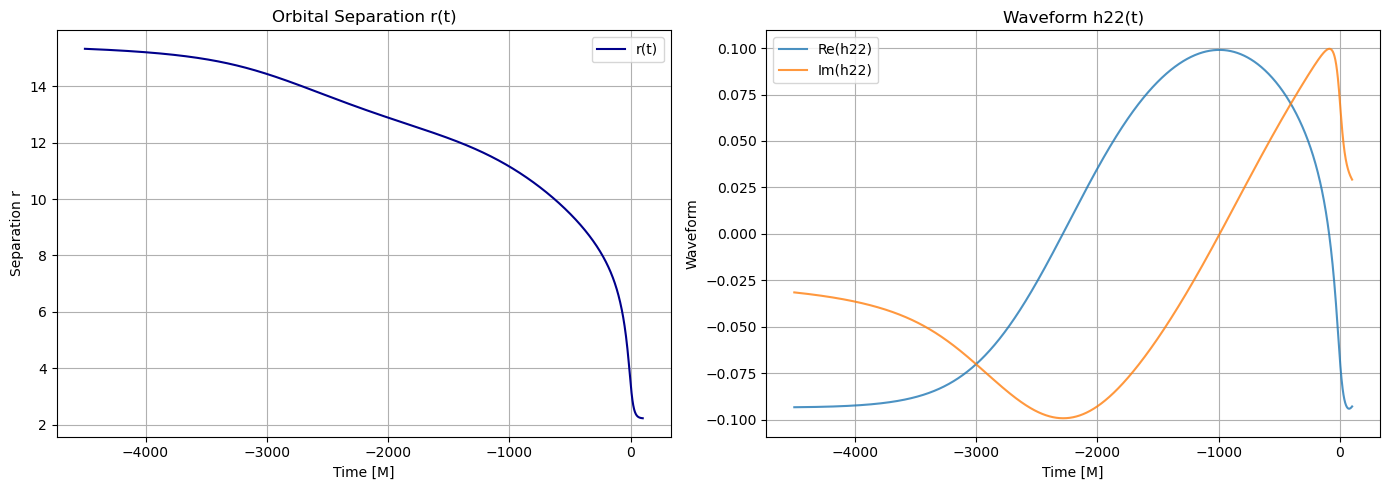

In [108]:
# Load trained model
model.eval()

# === Generate test input ===
q = 1.5
omega_0 = 0.02
t_vals = np.linspace(-4500, 100, 2000)

X_test = np.stack([
    t_vals,
    np.full_like(t_vals, q),
    # np.full_like(t_vals, omega_0)
], axis=1)

# === Scale inputs ===
X_scaled = gx.transform(X_test)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

# === Predict ===
with torch.no_grad():
    Y_scaled = model(X_tensor)
Y_pred = gy.inverse_transform(Y_scaled.numpy())

phi, r, omega, h_real, h_imag = Y_pred.T
h22 = h_real + 1j * h_imag

# === Plot results ===
plt.figure(figsize=(14, 5))

# --- Plot r(t) ---
plt.subplot(1, 2, 1)
plt.plot(t_vals, r, label='r(t)', color='darkblue')
plt.xlabel('Time [M]')
plt.ylabel('Separation r')
plt.title('Orbital Separation r(t)')
plt.grid(True)
plt.legend()

# --- Plot waveform h22 ---
plt.subplot(1, 2, 2)
plt.plot(t_vals, h_real, label='Re(h22)', alpha=0.8)
plt.plot(t_vals, h_imag, label='Im(h22)', alpha=0.8)
plt.xlabel('Time [M]')
plt.ylabel('Waveform')

plt.title('Waveform h22(t)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


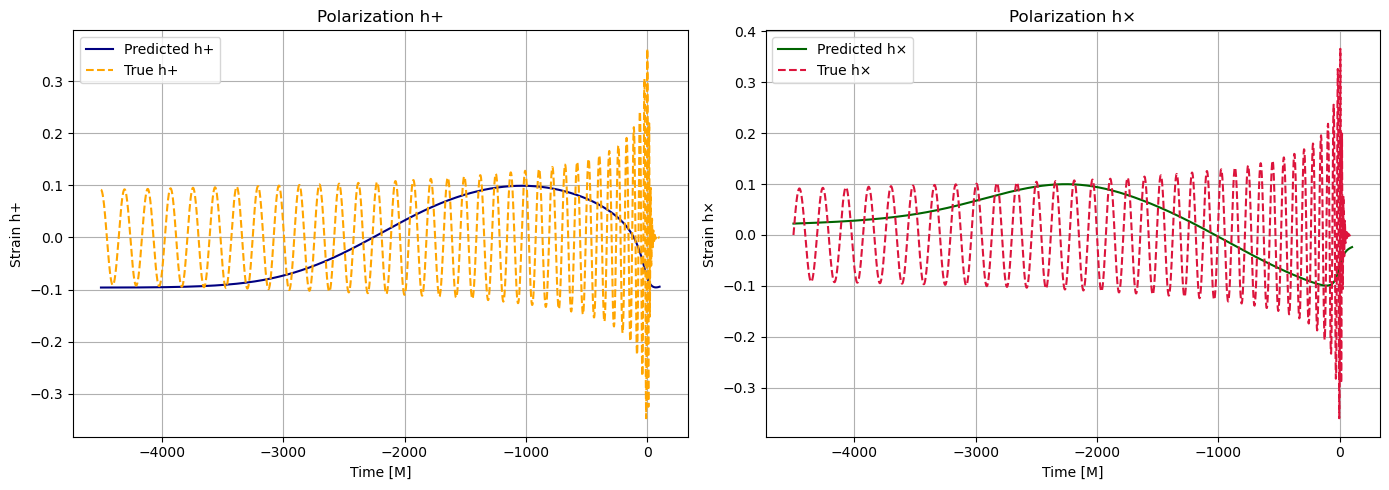

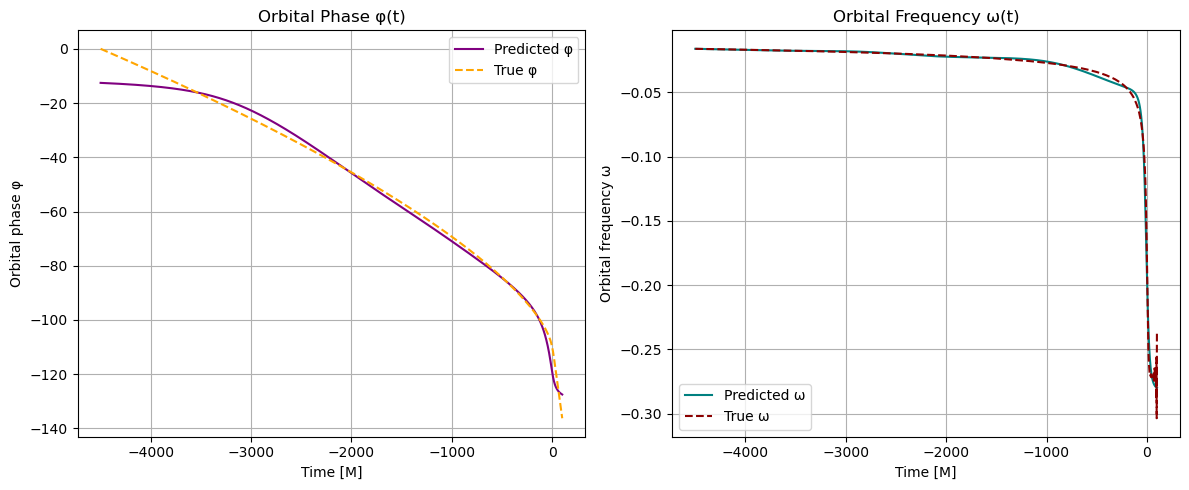

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd

# Load trained model
model.eval()

# === Generate test input ===
q = 1.5
t_vals = np.linspace(-4500, 100, 2000)

X_test = np.stack([
    t_vals,
    np.full_like(t_vals, q),
], axis=1)

# === Scale and predict ===
X_scaled = gx.transform(X_test)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
with torch.no_grad():
    Y_scaled = model(X_tensor)
Y_pred = gy.inverse_transform(Y_scaled.numpy())

phi, r, omega, h_real, h_imag = Y_pred.T
h22_pred = h_real + 1j * h_imag
hplus_pred = h_real
hcross_pred = -h_imag

# === Load ground truth ===
df = pd.read_csv("precessing_waveform_dataset.csv")
df_q = df[df['q'] == q].copy()
df_q = df_q[(df_q['time'] >= t_vals.min()) & (df_q['time'] <= t_vals.max())]
df_q = df_q.sort_values(by='time')

# === Interpolate ground truth ===
interp_phi = interp1d(df_q['time'], df_q['phi'], kind='cubic', fill_value="extrapolate")
interp_omega = interp1d(df_q['time'], df_q['omega'], kind='cubic', fill_value="extrapolate")
interp_r = interp1d(df_q['time'], df_q['r'], kind='cubic', fill_value="extrapolate")
interp_h_real = interp1d(df_q['time'], df_q['h22_real'], kind='cubic', fill_value="extrapolate")
interp_h_imag = interp1d(df_q['time'], df_q['h22_imag'], kind='cubic', fill_value="extrapolate")

phi_true = interp_phi(t_vals)
omega_true = interp_omega(t_vals)
r_true = interp_r(t_vals)
h_real_true = interp_h_real(t_vals)
h_imag_true = interp_h_imag(t_vals)
hplus_true = h_real_true
hcross_true = -h_imag_true

# === Plot results ===

# --- r, h+ and h× ---
plt.figure(figsize=(14, 5))
# plt.subplot(1, 3, 1)
# plt.plot(t_vals, r, label='Predicted r(t)', color='darkblue')
# plt.plot(t_vals, r_true, label='True r(t)', linestyle='--', color='orange')
# plt.xlabel('Time [M]')
# plt.ylabel('Separation r')
# plt.title('Orbital Separation r(t)')
# plt.grid(True)
# plt.legend()

plt.subplot(1, 2, 1)
plt.plot(t_vals, hplus_pred, label='Predicted h+', color='navy')
plt.plot(t_vals, hplus_true, '--', label='True h+', color='orange')
plt.xlabel('Time [M]')
plt.ylabel('Strain h+')
plt.title('Polarization h+')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t_vals, hcross_pred, label='Predicted h×', color='darkgreen')
plt.plot(t_vals, hcross_true, '--', label='True h×', color='crimson')
plt.xlabel('Time [M]')
plt.ylabel('Strain h×')
plt.title('Polarization h×')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# --- phi and omega ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(t_vals, phi, label='Predicted φ', color='purple')
plt.plot(t_vals, phi_true, '--', label='True φ', color='orange')
plt.xlabel('Time [M]')
plt.ylabel('Orbital phase φ')
plt.title('Orbital Phase φ(t)')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t_vals, omega, label='Predicted ω', color='teal')
plt.plot(t_vals, omega_true, '--', label='True ω', color='darkred')
plt.xlabel('Time [M]')
plt.ylabel('Orbital frequency ω')
plt.title('Orbital Frequency ω(t)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()




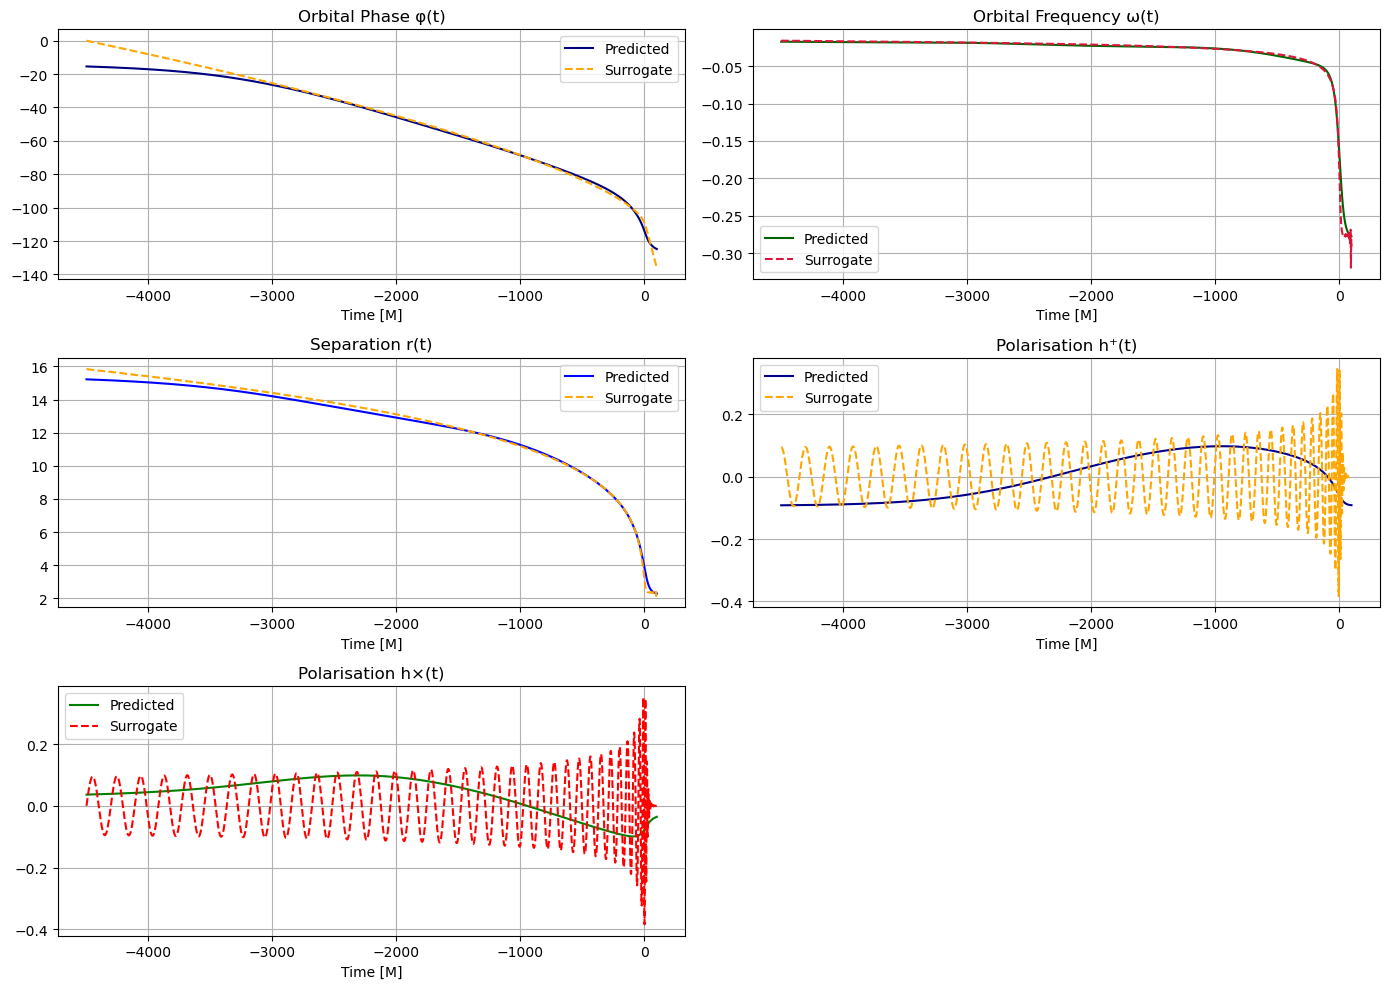

In [110]:
# Re-import everything after code execution state reset
from NRSur7dq2 import NRSurrogate7dq2
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
import joblib

# Load model and scalers (assumes they were saved as 'model.pth', 'gx.save', 'gy.save')
model.eval()

# Load surrogate
sur = NRSurrogate7dq2()

# === Generate test input for q = 1.35 ===
q = 1
t_vals = np.linspace(-4500, 100, 2000)

X_test = np.stack([t_vals, np.full_like(t_vals, q)], axis=1)
X_scaled = gx.transform(X_test)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
with torch.no_grad():
    Y_scaled = model(X_tensor)
Y_pred = gy.inverse_transform(Y_scaled.numpy())

phi_pred, r_pred, omega_pred, h_real_pred, h_imag_pred = Y_pred.T
hplus_pred = h_real_pred
hcross_pred = -h_imag_pred

# === Get surrogate reference ===
chiA = np.array([0.0, 0.0, 0.0])
chiB = np.array([0.0, 0.0, 0.0])
modes, *_ = sur(q, chiA, chiB, return_spins=True)
t_coorb = sur.t_coorb
h22 = modes[2, 2]
phi_true = np.unwrap(np.angle(h22)) / 2.0
omega_true = np.gradient(phi_true, t_coorb)
r_true = (1.0 / (omega_true ** 2 + 1e-8)) ** (1 / 3)
hplus_true = h22.real
hcross_true = -h22.imag

# === Interpolate surrogate outputs to match PINN t_vals ===
phi_true_interp = interp1d(t_coorb, phi_true, kind='cubic', fill_value="extrapolate")(t_vals)
omega_true_interp = interp1d(t_coorb, omega_true, kind='cubic', fill_value="extrapolate")(t_vals)
r_true_interp = interp1d(t_coorb, r_true, kind='cubic', fill_value="extrapolate")(t_vals)
hplus_true_interp = interp1d(t_coorb, hplus_true, kind='cubic', fill_value="extrapolate")(t_vals)
hcross_true_interp = interp1d(t_coorb, hcross_true, kind='cubic', fill_value="extrapolate")(t_vals)

# === Plot ===
fig, axs = plt.subplots(3, 2, figsize=(14, 10))
axs = axs.flatten()

axs[0].plot(t_vals, phi_pred, label="Predicted", color='navy')
axs[0].plot(t_vals, phi_true_interp, '--', label="Surrogate", color='orange')
axs[0].set_title("Orbital Phase φ(t)")
axs[0].set_xlabel("Time [M]")
axs[0].grid(); axs[0].legend()

axs[1].plot(t_vals, omega_pred, label="Predicted", color='darkgreen')
axs[1].plot(t_vals, omega_true_interp, '--', label="Surrogate", color='crimson')
axs[1].set_title("Orbital Frequency ω(t)")
axs[1].set_xlabel("Time [M]")
axs[1].grid(); axs[1].legend()

axs[2].plot(t_vals, r_pred, label="Predicted", color='blue')
axs[2].plot(t_vals, r_true_interp, '--', label="Surrogate", color='orange')
axs[2].set_title("Separation r(t)")
axs[2].set_xlabel("Time [M]")
axs[2].grid(); axs[2].legend()

axs[3].plot(t_vals, hplus_pred, label="Predicted", color='darkblue')
axs[3].plot(t_vals, hplus_true_interp, '--', label="Surrogate", color='orange')
axs[3].set_title("Polarisation h⁺(t)")
axs[3].set_xlabel("Time [M]")
axs[3].grid(); axs[3].legend()

axs[4].plot(t_vals, hcross_pred, label="Predicted", color='green')
axs[4].plot(t_vals, hcross_true_interp, '--', label="Surrogate", color='red')
axs[4].set_title("Polarisation h×(t)")
axs[4].set_xlabel("Time [M]")
axs[4].grid(); axs[4].legend()

axs[5].axis('off')
plt.tight_layout()
plt.show()


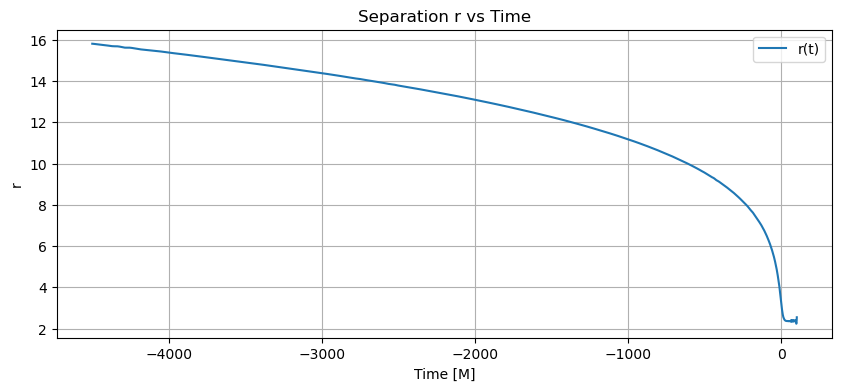

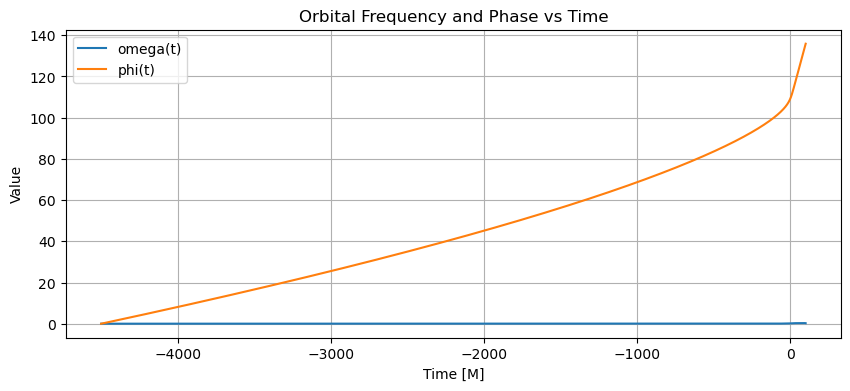

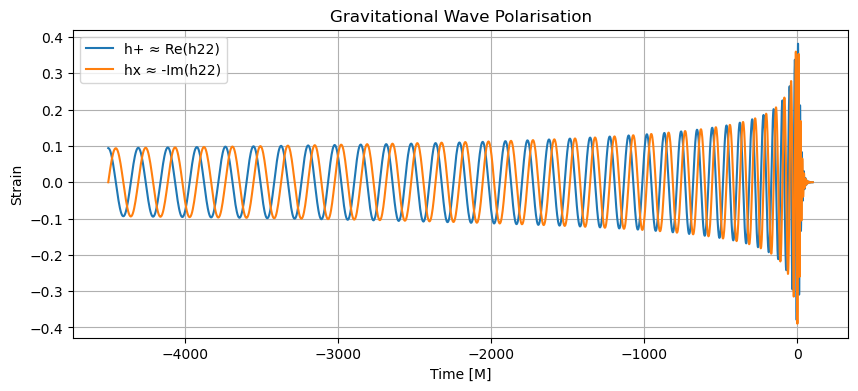

In [13]:
from NRSur7dq2 import NRSurrogate7dq2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sur = NRSurrogate7dq2()
q_values = [1.2, 1.5, 1.8, 2.0]  # Mass ratios
all_rows = []

for q in q_values:
    chiA = np.array([0.0, 0.0, 0.0])
    chiB = np.array([0.0, 0.0, 0.0])

    try:
        modes, chiA_t, chiB_t = sur(q, chiA, chiB, return_spins=True)
        quat, phi_orb, chiA_dyn, chiB_dyn = sur.get_dynamics(q, chiA, chiB)
        quat = quat.T
    except Exception as e:
        print(f"Error for q={q}: {e}")
        continue

    t = sur.t_coorb
    h22 = modes[2, 2]

    phi = -np.unwrap(np.angle(h22)) / 2.0
    omega = np.gradient(phi, t)
    r = (1.0 / (omega**2 + 1e-8))**(1 / 3)

    omega_0 = omega[0]
    r_0 = r[0]

    for i in range(len(t)):
        row = {
            "time": t[i],
            "q": q,
            "r": r[i],
            "r_0": r_0,
            "omega": omega[i],
            "omega_0": omega_0,
            "h22_real": h22[i].real,
            "h22_imag": h22[i].imag,
            "phi": phi[i],
        }
        all_rows.append(row)

# Guardar CSV
df = pd.DataFrame(all_rows)

# --- Plot para q = 1.2 ---
df_q = df[df["q"] == q_values[0]]

plt.figure(figsize=(10, 4))
plt.plot(df_q["time"], df_q["r"], label="r(t)")
plt.title("Separation r vs Time")
plt.xlabel("Time [M]")
plt.ylabel("r")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(df_q["time"], df_q["omega"], label="omega(t)")
plt.plot(df_q["time"], df_q["phi"], label="phi(t)")
plt.title("Orbital Frequency and Phase vs Time")
plt.xlabel("Time [M]")
plt.ylabel("Value")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(df_q["time"], df_q["h22_real"], label="h+ ≈ Re(h22)")
plt.plot(df_q["time"], -df_q["h22_imag"], label="hx ≈ -Im(h22)")
plt.title("Gravitational Wave Polarisation")
plt.xlabel("Time [M]")
plt.ylabel("Strain")
plt.grid()
plt.legend()
plt.show()
